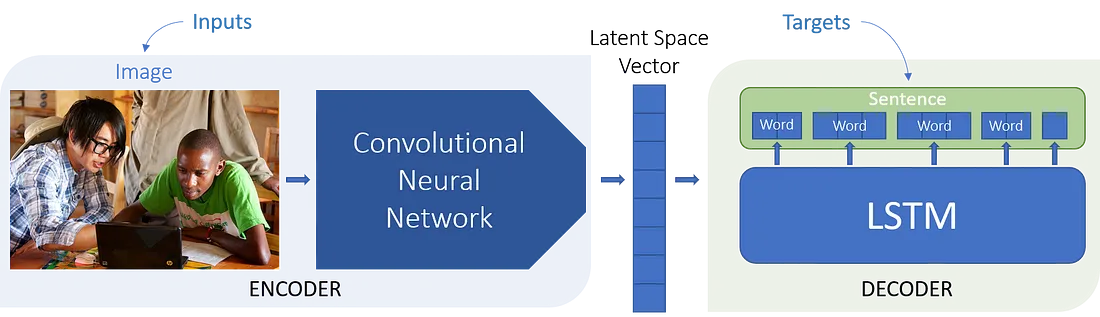

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import random
import re
from collections import Counter
from sklearn.manifold import TSNE

# Load CIFAR-10
def load_data():
    (x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype("float32") / 255.0
    y_train = y_train.flatten()
    return x_train, y_train

# Generate diverse captions
captions_dict = {
    0: ["A flying airplane", "Aircraft in the sky", "Jet plane soaring"],
    1: ["A red car", "A small automobile", "A speeding vehicle"],
    2: ["A blue bird", "A small flying bird", "Bird in flight"],
    3: ["A cute cat", "A furry feline", "A small kitten"],
    4: ["A wild deer", "A running deer", "Deer in the forest"],
    5: ["A brown dog", "A barking dog", "Dog playing around"],
    6: ["A green frog", "Frog on a leaf", "Jumping frog"],
    7: ["A racing horse", "Horse on the field", "A galloping horse"],
    8: ["A big ship", "Ship on the sea", "A sailing vessel"],
    9: ["A large truck", "Truck on the road", "A heavy vehicle"]
}

def generate_caption_from_class(label):
    return random.choice(captions_dict[label])

# Build vocabulary
def build_vocab(captions, vocab_size=1000):
    all_words = []
    for caption in captions:
        words = re.findall(r'\b\w+\b', caption.lower())
        all_words.extend(words)
    freq = Counter(all_words).most_common(vocab_size - 4)
    vocab = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
    for idx, (word, _) in enumerate(freq, start=4):
        vocab[word] = idx
    return vocab

def preprocess_caption(caption, vocab):
    tokens = re.findall(r'\b\w+\b', caption.lower())
    token_ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    return [vocab["<SOS>"]] + token_ids + [vocab["<EOS>"]]

# Create embedding model for images
def create_image_model():
    base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(32, 32, 3), pooling='avg')
    base_model.trainable = False
    inputs = layers.Input(shape=(32, 32, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    features = base_model(x)
    outputs = layers.Dense(256, activation='relu')(features)
    return models.Model(inputs, outputs)


In [4]:

# Create caption decoder
class CaptionDecoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512):
        super(CaptionDecoder, self).__init__()
        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(hidden_dim, return_sequences=True, return_state=True)
        self.dense = layers.Dense(vocab_size)

    def call(self, features, captions):
        captions = self.embedding(captions)
        features = tf.expand_dims(features, 1)
        x = tf.concat([features, captions], axis=1)
        x, _ = self.gru(x)
        return self.dense(x)

# Plot image embeddings in 2D space
def plot_image_embeddings(encoder, images, labels):
    features = encoder.predict(images)
    tsne = TSNE(n_components=2, perplexity=30)
    reduced = tsne.fit_transform(features)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.legend(handles=scatter.legend_elements()[0], labels=list(captions_dict.keys()))
    plt.title("t-SNE visualization of image embeddings")
    plt.show()



In [6]:

# Training preparation
x_train, y_train = load_data()
captions = [generate_caption_from_class(label) for label in y_train]
VOCAB = build_vocab(captions)
IDX_TO_WORD = {idx: word for word, idx in VOCAB.items()}
VOCAB_SIZE = len(VOCAB)

caption_seqs = [preprocess_caption(c, VOCAB) for c in captions]
max_len = max(len(seq) for seq in caption_seqs)
caption_seqs = tf.keras.preprocessing.sequence.pad_sequences(caption_seqs, maxlen=max_len, padding='post', value=VOCAB["<PAD>"])

# Create models
image_encoder = create_image_model()
caption_decoder = CaptionDecoder(VOCAB_SIZE)

# Compile
inputs_img = tf.convert_to_tensor(x_train[:1000])
inputs_cap = tf.convert_to_tensor(caption_seqs[:1000])
features = image_encoder(inputs_img)

caption_inputs = inputs_cap[:, :-1]
caption_targets = inputs_cap[:, 1:]

caption_decoder.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)



2025-04-07 07:52:34.729855: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-07 07:52:34.730039: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-07 07:52:34.730098: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.56MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-07 07:52:34.730125: W external/local_xla/xla

NotFoundError: Exception encountered when calling Conv2D.call().

[1m{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 99679452 bytes. [tf-allocator-allocation-error='']
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes. [tf-allocator-allocation-error='']
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes. [tf-allocator-allocation-error='']
  Profiling failure on CUDNN engine eng35{k2=1,k5=3,k14=2}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 39931408 bytes. [tf-allocator-allocation-error='']
  Profiling failure on CUDNN engine eng56{k2=1,k12=-1,k13=0,k14=3,k15=0,k17=3,k18=1,k22=0,k23=0}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 171019568 bytes. [tf-allocator-allocation-error='']
  Profiling failure on CUDNN engine eng55{k2=8,k13=1,k14=3,k18=1,k22=0,k23=0}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 105467408 bytes. [tf-allocator-allocation-error='']
  Profiling failure on CUDNN engine eng54{k2=8,k12=-1,k13=1,k14=3,k15=0,k17=3,k18=1,k23=0}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 105531568 bytes. [tf-allocator-allocation-error='']
  Profiling failure on CUDNN engine eng56{k2=8,k12=-1,k13=1,k14=3,k15=0,k17=3,k18=1,k22=0,k23=0}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 171067568 bytes. [tf-allocator-allocation-error='']
  Profiling failure on CUDNN engine eng4{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 683682448 bytes. [tf-allocator-allocation-error=''] [Op:Conv2D][0m

Arguments received by Conv2D.call():
  • inputs=tf.Tensor(shape=(1000, 38, 38, 3), dtype=float32)

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
import nltk
nltk.download('punkt')

# Vocabulary
VOCAB = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3,
         "A": 4, "red": 5, "car": 6, "blue": 7, "dog": 8, "cat": 9, "truck": 10, "bird": 11}
IDX_TO_WORD = {idx: word for word, idx in VOCAB.items()}
VOCAB_SIZE = len(VOCAB)

# Parameters
EMBED_DIM = 256
HIDDEN_DIM = 512
BATCH_SIZE = 64
EPOCHS = 5
MAX_CAPTION_LEN = 6

# Generate captions for CIFAR-10
def generate_captions():
    class_labels = ["airplane", "automobile", "bird", "cat", "deer",
                    "dog", "frog", "horse", "ship", "truck"]
    captions = {i: f"A {color} {class_labels[i]}" for i, color in enumerate(
        ["red", "blue", "green", "yellow", "black", "white", "purple", "orange", "gray", "brown"]
    )}
    return captions

captions_dict = generate_captions()

# Preprocess captions
def preprocess_caption(caption):
    tokens = caption.split()
    token_ids = [VOCAB.get(w, VOCAB["<UNK>"]) for w in tokens]
    token_ids = [VOCAB["<SOS>"]] + token_ids + [VOCAB["<EOS>"]]
    return token_ids

# Load CIFAR-10 and create dataset
def load_dataset():
    (x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255.0
    captions = [preprocess_caption(captions_dict[label[0]]) for label in y_train]
    captions_padded = pad_sequences(captions, maxlen=MAX_CAPTION_LEN, padding='post', value=VOCAB["<PAD>"])
    return x_train, captions_padded

images, captions = load_dataset()

# Encoder model
def build_encoder():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3), pooling='avg')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(32, 32, 3))
    features = base_model(inputs)
    outputs = layers.Dense(EMBED_DIM)(features)
    return tf.keras.Model(inputs, outputs, name='image_encoder')

# Decoder model
def build_decoder():
    image_inputs = tf.keras.Input(shape=(EMBED_DIM,))
    caption_inputs = tf.keras.Input(shape=(MAX_CAPTION_LEN - 1,))
    x = layers.Embedding(VOCAB_SIZE, EMBED_DIM)(caption_inputs)
    x = tf.concat([tf.expand_dims(image_inputs, 1), x], axis=1)
    x = layers.GRU(HIDDEN_DIM, return_sequences=True)(x)
    outputs = layers.Dense(VOCAB_SIZE, activation='softmax')(x)
    return tf.keras.Model([image_inputs, caption_inputs], outputs, name='caption_decoder')

# Prepare training data
decoder_input = captions[:, :-1]
decoder_target = captions[:, 1:]

# Build and compile models
encoder = build_encoder()
decoder = build_decoder()

decoder.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train
features = encoder.predict(images, batch_size=BATCH_SIZE)
decoder.fit([features, decoder_input], np.expand_dims(decoder_target, -1),
            batch_size=BATCH_SIZE, epochs=EPOCHS)

# Caption generation
def generate_caption_tf(image, max_len=10):
    feature = encoder(tf.expand_dims(image, 0))
    caption = [VOCAB["<SOS>"]]

    for _ in range(max_len):
        input_seq = pad_sequences([caption], maxlen=MAX_CAPTION_LEN-1, padding='post')
        prediction = decoder.predict([feature, input_seq])
        next_id = np.argmax(prediction[0, -1, :])
        if next_id == VOCAB["<EOS>"]:
            break
        caption.append(next_id)
    return " ".join(IDX_TO_WORD.get(idx, "<UNK>") for idx in caption[1:])

# BLEU evaluation
def evaluate_bleu_tf(images, captions):
    features = encoder.predict(images)
    total_score, count = 0, 0
    for i in range(len(images)):
        true_caption = [IDX_TO_WORD[idx] for idx in captions[i] if idx not in [0, 1, 2]]
        generated = generate_caption_tf(images[i])
        bleu = sentence_bleu([true_caption], generated.split())
        total_score += bleu
        count += 1
        if count >= 100: break
    return total_score / count

bleu_score = evaluate_bleu_tf(images, captions)
print(f"BLEU Score: {bleu_score:.4f}")

# t-SNE visualization
def visualize_embeddings_tsne():
    features = encoder.predict(images[:200])
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(features)
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7, c='purple')
    plt.title("t-SNE of Image Embeddings")
    plt.show()

visualize_embeddings_tsne()

# Show sample generated captions
def show_sample_predictions(n=5):
    plt.figure(figsize=(15, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        image = images[i]
        plt.imshow(image)
        caption = generate_caption_tf(image)
        plt.title(caption, fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_predictions()


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:

caption_decoder.fit([features, caption_inputs], caption_targets, batch_size=224, epochs=5)


In [ ]:
# Visualize embeddings
plot_image_embeddings(image_encoder, x_train[:100], y_train[:100])